In [29]:
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm

from main import main_data_loader

train_dataloader, val_dataloader, test_dataloader = main_data_loader()
model = torch.load("bilstm_1/bilstm_1_25.pth", map_location="cpu")

model.eval()  # 设置为评估模式
true_labels = []
predicted_probs = []
threshold = 0.50
# 对测试数据进行预测
with torch.no_grad():
    for item in tqdm(test_dataloader):
        data, targets = item
        data = data.float()
        targets = targets.long()
        outputs = model(data).float()
        true_labels.append(targets.numpy())
        predicted_probs.append(outputs.numpy())
predicted_probs_flat = np.concatenate(predicted_probs)  # 将所有预测概率展平成一个数组
true_labels_flat = np.concatenate(true_labels)  # 将所有真实标签展平成一个数组
fpr, tpr, thresholds = roc_curve(true_labels_flat, predicted_probs_flat)
roc_auc = auc(fpr, tpr)

100%|██████████| 778/778 [00:16<00:00, 48.24it/s]


In [32]:
# 选择最佳阈值
best_threshold_index = (1.1 * tpr - fpr).argmax()
best_threshold = thresholds[best_threshold_index]

AUC: 0.737323079797539
Best threshold: 0.45385444


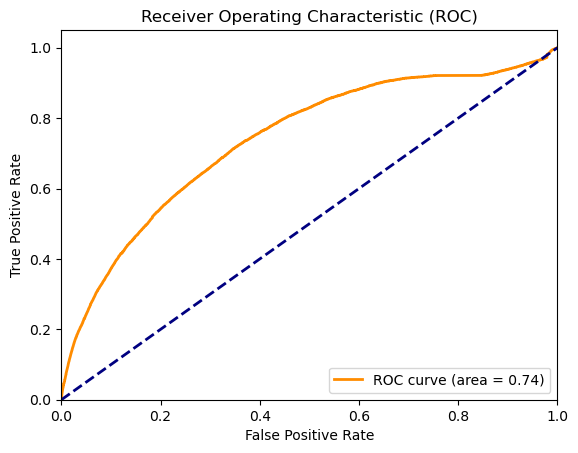

In [34]:

print("AUC:", roc_auc)
print("Best threshold:", best_threshold)
# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [35]:
TP = np.sum((predicted_probs_flat > best_threshold) & (true_labels_flat == 1))
FP = np.sum((predicted_probs_flat > best_threshold) & (true_labels_flat == 0))
TN = np.sum((predicted_probs_flat <= best_threshold) & (true_labels_flat == 0))
FN = np.sum((predicted_probs_flat <= best_threshold) & (true_labels_flat == 1))

confusion_matrix = np.array([[TN, FP], [FN, TP]])
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
[[53742 31641]
 [ 3738 10421]]


In [36]:
specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print("Specificity:", specificity)
print("Sensitivity:", sensitivity)
print("Accuracy:", accuracy)

Specificity: 0.6294227188081937
Sensitivity: 0.7359983049650399
Accuracy: 0.6445821864137751


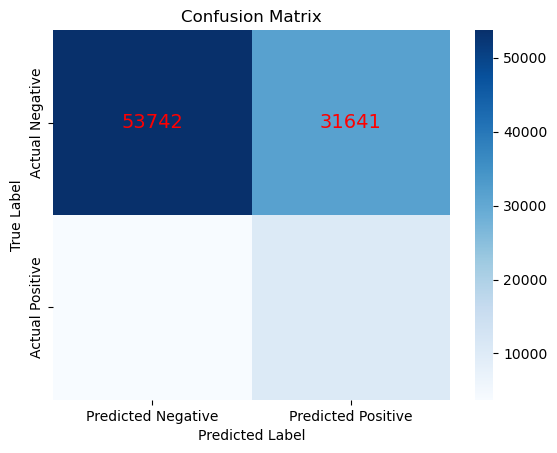

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制混淆矩阵
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"],
            annot_kws={"size": 14, "color": 'red'})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()